## Importing the needed libraries

In [232]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

### Set seed

1. For comparable results set the random seed in both numpy and tensorflow to (123). You can use this code:

In [233]:
np.random.seed(123)
tf.random.set_seed(123)

    2. If you don’t work in google colab, import the appropriate metric that will be used for optimization (remember you are predicting a continuous, not categorical variable).

    3. To download the csv file from github use !wget -nc https://lazyprogrammer.me/course_files/airline_passengers.csv

## Importing the dataset

4. Create your data frame. To ensure that all works fine index the ‘Month’ column and parse the dates.

In [234]:
#Because time series are ordered sequences we need to indicate the column according to wich the rows will be indexed
#parse_date will put the column with dates in the year/month/day format
df = pd.read_csv('airline_passengers.csv', index_col='Month', parse_dates=True)

Check how the dataset looks

In [235]:
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


5. Plot the data and check for stationarity. You can use the Dickey Fuller test to do this. Or if you would rather rely just on visual inspection, argument your conclusion on whether data are stationary or not. Remember, for stationarity you will want a constant variance (i.e. variance is not increasing/decreasing with time) and no trend in your data. If data proved to be non-stationary correct for this problem. (to correct for variance issues you can log transform the data, for trend, you can take the first difference).

### Dickey Fuller test

In [236]:
# Dickey Fuller test
# The null hypothesis of the Dickey Fuller test is that there is a unit root in the time series.
# The alternative hypothesis is that there is no unit root.
# The test statistic is the largest eigenvalue of the covariance matrix of the series.
# The p-value is the probability of obtaining a test statistic as large as the one that was actually observed,
# assuming that the true distribution of the test statistic is normal.
# The test statistic is approximately normally distributed if the p-value is small.

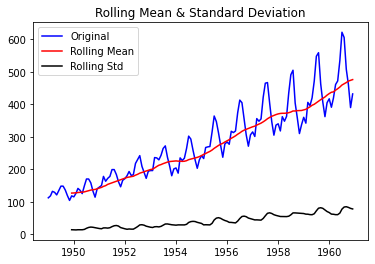

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64
The data is not stationary


In [237]:
from statsmodels.tsa.stattools import adfuller


def test_stationarity(timeseries):
    # rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    # plot rolling statistics:
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    
    return dfoutput

test_result = test_stationarity(df['Passengers'])
print(test_result)

if test_result['p-value'] < 0.05:
    print('The data is stationary')
else:
    print('The data is not stationary')

As we can see, the data are not stationary becasue p-value is greater than 0.05.

### Viasualizing the data to detect non-stationarity, variance and trend

<AxesSubplot:xlabel='Month'>

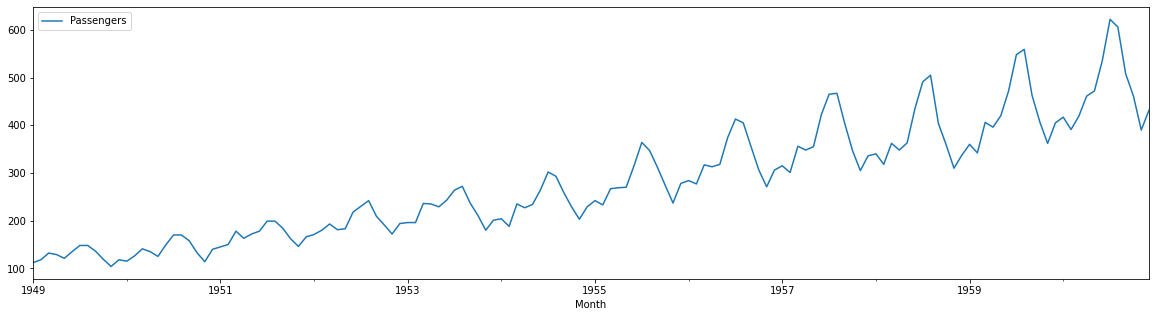

In [238]:
df.plot(figsize=(20, 5))

From the graph we can see that the data is not stationary it also has a positive trend. There is also seasonality and variance. The variance is increasing in time which which is called heteroskedasticity.

##### Fixing the data

We will first take the first difference to see if it fixes any of the problems mentioned above.

In [239]:
df['1stdiff'] = df['Passengers'].diff()

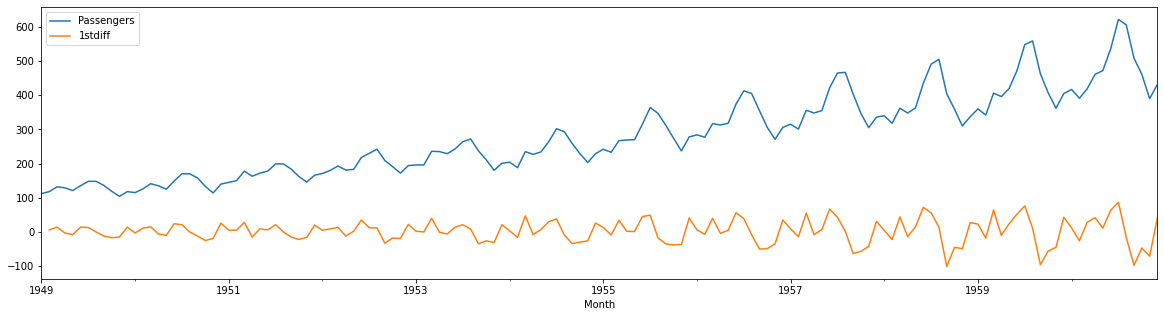

In [240]:
df.plot(figsize=(20, 5));

After taking the first difference we can see that the trend was removed. But there is still some seasonality and a variance that increases with time. 
Since it is common to use log function together with the first difference in order to solved the non-stationarity issues, next will be used the log transformation and the results will be analized.

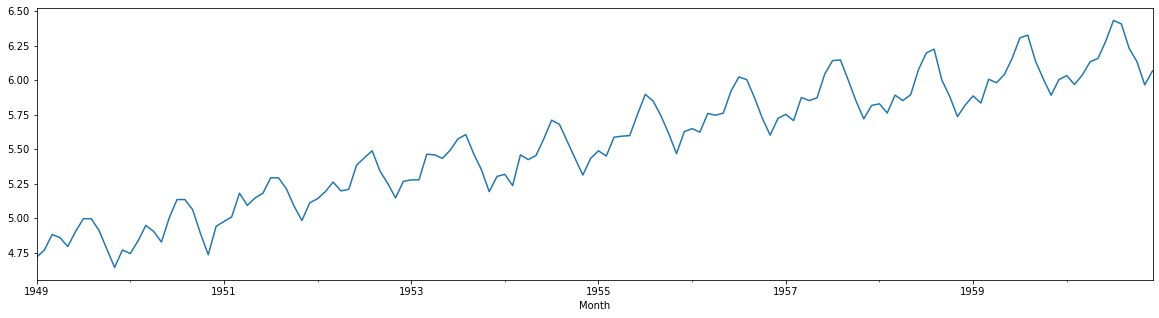

In [241]:
df['LogPassengers'] = np.log(df['Passengers'])
df['LogPassengers'].plot(figsize=(20, 5));

We can see that the log function helped to remove the variance with time. The log transformation did not remove the trend, but the differenciation did, because of this will will use the two function combined in the next step. The log transformation did not solve the problem with seasonality and heteroskedasticity.

Use Log transformation in combination with the first difference

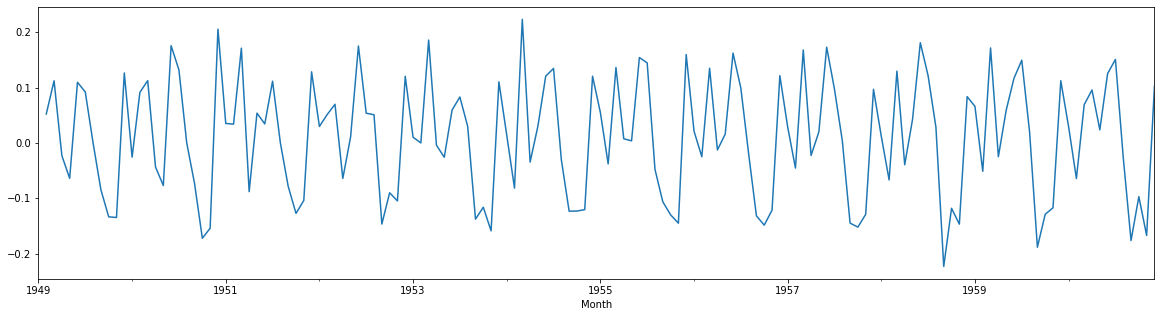

In [242]:
df['Log1stDiff'] = df['LogPassengers'].diff()
df['Log1stDiff'].plot(figsize=(20, 5));

This time we have got a much better result. The result is not perfect because there is some cyclicality, with this should work for our model.

### Create the train and test sets

Because time series are sequences, we'll take the *y* values for the last 12 months and assign them to the test set, and the rest will go into the training set.

In [243]:
df.index.freq = 'MS'

Ntest = 12
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]

7. Create the index arrays for both train and test datasets. If you don’t remember how to do this from our ML class here is one example: train_idx = df.index <= train.index[-1], so just do the same for the test set.

In [244]:
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

In [245]:
# taking a look at the dataset
print(df)

# get first value of Passengers, needed for reverse differencing
first_passengers_value = df.loc[train.index[0], 'Passengers']

            Passengers  1stdiff  LogPassengers  Log1stDiff
Month                                                     
1949-01-01         112      NaN       4.718499         NaN
1949-02-01         118      6.0       4.770685    0.052186
1949-03-01         132     14.0       4.882802    0.112117
1949-04-01         129     -3.0       4.859812   -0.022990
1949-05-01         121     -8.0       4.795791   -0.064022
...                ...      ...            ...         ...
1960-08-01         606    -16.0       6.406880   -0.026060
1960-09-01         508    -98.0       6.230481   -0.176399
1960-10-01         461    -47.0       6.133398   -0.097083
1960-11-01         390    -71.0       5.966147   -0.167251
1960-12-01         432     42.0       6.068426    0.102279

[144 rows x 4 columns]


8. Create the appropriate data structure for a time series analysis where the past 10 datapoints will be used to make predictions of the next 1 datapoint.

In [246]:
# prepare dataset for RNN
def prepare_dataset(df, look_back=1):
    X, Y = [], []
    for i in range(len(df) - look_back):
        X.append(df[i:(i+look_back)])
        Y.append(df[i+look_back])
    return np.array(X), np.array(Y)

look_back = 10
n_features = 1

# using Log1stDiff
df = df.fillna(0)
X, Y = prepare_dataset(df['Log1stDiff'], look_back)


for i in range(len(X)):
    print(X[i], Y[i])

[ 0.          0.05218575  0.1121173  -0.02298952 -0.06402186  0.10948423
  0.0919375   0.         -0.08455739 -0.13353139] -0.13473259397015713
[ 0.05218575  0.1121173  -0.02298952 -0.06402186  0.10948423  0.0919375
  0.         -0.08455739 -0.13353139 -0.13473259] 0.12629372532429262
[ 0.1121173  -0.02298952 -0.06402186  0.10948423  0.0919375   0.
 -0.08455739 -0.13353139 -0.13473259  0.12629373] -0.025752496102414923
[-0.02298952 -0.06402186  0.10948423  0.0919375   0.         -0.08455739
 -0.13353139 -0.13473259  0.12629373 -0.0257525 ] 0.09134977858822779
[-0.06402186  0.10948423  0.0919375   0.         -0.08455739 -0.13353139
 -0.13473259  0.12629373 -0.0257525   0.09134978] 0.11247798342669046
[ 0.10948423  0.0919375   0.         -0.08455739 -0.13353139 -0.13473259
  0.12629373 -0.0257525   0.09134978  0.11247798] -0.04348511193973881
[ 0.0919375   0.         -0.08455739 -0.13353139 -0.13473259  0.12629373
 -0.0257525   0.09134978  0.11247798 -0.04348511] -0.07696104113612812
[ 0

9. Reshape your created dataframe into the 3D format that RNN expects.

In [247]:
# reshape input to be [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], n_features))

10. Create the X_train, y_train, X_test and y_test.

In [248]:
# split into train and test sets
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
trainX, testX = X[0:train_size, :, :], X[train_size:len(X), :, :]
trainY, testY = Y[0:train_size], Y[train_size:len(Y)]

In [249]:
print(len(trainY))

107


11. Create a one-layer RNN with 25 units (neurons). Train it for 100 epochs with the default mini batch size of 32

12. Compile and fit the model. When compiling, specify the ‘sgd’ optimizer, and choose an accuracy metric (e.g. mse, mae, mape, etc.) to judge the goodness of your predictions. 
To compare further on the prediction results with the true values in the test set, specify inside the fit function your validation data: validation_data = (X_test, y_test). 
Save the history of the loss and the accuracy results in each epoch as the model is being trained, so that you can later on plot them and compare.

In [250]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

model = Sequential()
model.add(LSTM(25, activation='relu', input_shape=(look_back, n_features)))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
history = model.fit(trainX, trainY, epochs=100, batch_size=32, validation_data=(testX, testY))

Epoch 1/100
4/4 [==============================] - 1s 39ms/step - loss: 0.0111 - val_loss: 0.0122
Epoch 2/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0109 - val_loss: 0.0121
Epoch 3/100
4/4 [==============================] - 0s 6ms/step - loss: 0.0109 - val_loss: 0.0122
Epoch 4/100
4/4 [==============================] - 0s 6ms/step - loss: 0.0108 - val_loss: 0.0121
Epoch 5/100
4/4 [==============================] - 0s 6ms/step - loss: 0.0107 - val_loss: 0.0120
Epoch 6/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0107 - val_loss: 0.0118
Epoch 7/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0105 - val_loss: 0.0116
Epoch 8/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0104 - val_loss: 0.0115
Epoch 9/100
4/4 [==============================] - 0s 6ms/step - loss: 0.0104 - val_loss: 0.0113
Epoch 10/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0103 - val_loss: 0.0112
Epoch 11/100
4/4 [==========

13. Plot the loss and accuracy in each epoch for the training set as well as the validation set. Comment on your results. Do you see signs of overfitting? If yes, explain. If no, explain.

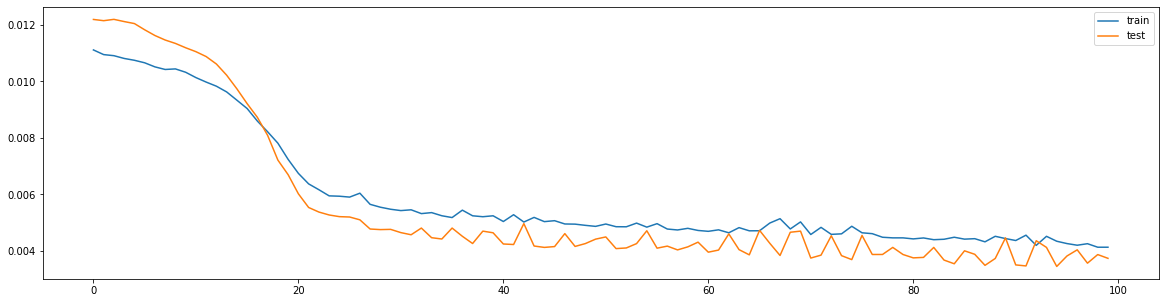

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

14. Do you see signs of vanishing or exploding gradient? Explain how the two would manifest in your graph. 

In [ ]:
# response

15. Compute the model predictions, undo the differencing and plot the results.

112
    Prediction
0   111.965645
1   112.005623
2   112.034523
3   112.118523
4   112.167236
..         ...
22  112.889046
23  112.729378
24  112.591187
25  112.547951
26  112.605927

[134 rows x 1 columns]


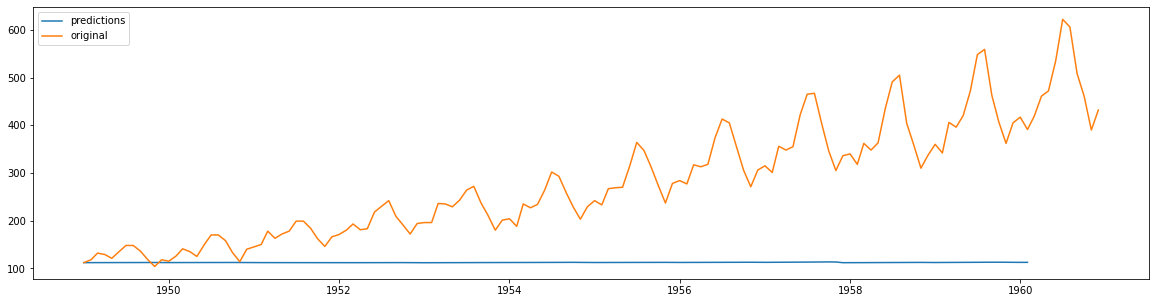

In [ ]:
# Compute the model predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

def rebuild_diffed(series: pd.DataFrame, first_element_original):
    cumsum = series.cumsum()
    return cumsum.fillna(0) + first_element_original

# create dataframe from the predictions
trainPredict = pd.DataFrame(trainPredict)
trainPredict.columns = ['Prediction']


# create dataframe from the predictions
testPredict = pd.DataFrame(testPredict)
testPredict.columns = ['Prediction']


print(first_passengers_value)
# undo the differencing
trainPredict = rebuild_diffed(trainPredict, first_passengers_value)
testPredict = rebuild_diffed(testPredict, first_passengers_value)

# # concatenate trainPred and testPredict
# predictions = pd.concat([trainPredict, testPredict], axis=0)
# print(predictions)
# # set the index same as the original data, but withou the first 10 elements
# predictions.index = df.index[10:]

# plot the results
plt.figure(figsize=(20, 5))
plt.plot(trainPredict, label='train')
plt.plot(testPredict, label='test')
plt.legend()
plt.show()

16. Now try other options and see if you can beat your initial predictions:


    a) Train the model for 500 epochs. Are your predictions better? Should you have stopped before the end of the 500 epochs judging by your loss and accuracy plots? If yes at what epoch would you stop and why?
    
    b) Try two, three, and four  layers for your RNN with 50 and 100 neurons in each of the hidden layers (you should get altogether 6 models – 2 layers & 50 neurons, 2 layers & 100 neurons, 3 layers & 50 neurons, etc.). Train each of them for 100 epochs and save and plot the accuracies and the losses for each of the 6 combinations. Do you see signs of overfitting? Which model overfits most? Explain.
    
    c) For the most severely overfitting model from the 6 options above use the Dropuot in combination with the L2 method, to regularize your overfitting model. Be creative, try different options to correct for the overfit. 
    
    d) Could you create a model that beats the first one (the one with 1 layer and 25 units) and is not overfitting after regularization was applied?


In [ ]:
# response